In [ ]:
%reset

# 新段落

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
import scipy
import time as t

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float64)
torch.manual_seed(13)



# Sampling parameters etc
#n_axis = 51
n_axis = 61
#n_time = 131
n_time = 101

axis = torch.linspace(0,3,n_axis, device=device)
time = torch.linspace(0,1,n_time, device=device)
Ps = torch.cartesian_prod(axis,axis,time)
# Number of points
lP = Ps.shape[0]


# Initial dataset
data_axis = torch.linspace(0,4, 81, device=device)
data_time = torch.linspace(0,1,101, device=device)
data_Ps = torch.cartesian_prod(data_axis,data_axis,data_time)
#data_Ps = torch.cartesian_prod(axis,axis,time)

#mask = torch.logical_and((abs(data_Ps[:,0] - 2)-1)==0,(abs(data_Ps[:,1] - 2)-1)==0)
mask = data_Ps[:,2] == 0.
X = data_Ps[mask]

maskBC = torch.logical_or(data_Ps[:,0] == 0, data_Ps[:,1] == 0)
Xbc = data_Ps[maskBC]

#mask1 = abs(data_Ps[:,0]) == 2.
#dyX = data_Ps[mask1]

#mask2 = abs(data_Ps[:,1]) == 2.
#dxX = data_Ps[mask2]

#Y = torch.exp(-(X[:,0]-2)**2*5)+torch.exp(-(X[:,1]+X[:,0]-4)**2*5)
#Y = 10*(scipy.special.jv(0,(10*((X[:,0]-2)**2+(X[:,1]-2)**2)**0.5).to("cpu"))+scipy.special.jv(0,(10*((X[:,0]+2)**2+(X[:,1]-2)**2)**0.5).to("cpu"))).to(device)
#Y += 5*(scipy.special.jv(0,(5*((X[:,0]-1)**2+(X[:,1]-1)**2)**0.5).to("cpu"))+scipy.special.jv(0,(5*((X[:,0]+1)**2+(X[:,1]-1)**2)**0.5).to("cpu"))).to(device)
#Y += 5*(scipy.special.jv(0,(5*((X[:,0]-3)**2+(X[:,1]-3)**2)**0.5).to("cpu"))+scipy.special.jv(0,(5*((X[:,0]+3)**2+(X[:,1]-3)**2)**0.5).to("cpu"))).to(device)
#Y = [2.,3.,3.,1.]
#Y = torch.tensor(Y, device=device)
#Y = torch.cos((X[:,0]-1)*5)+torch.cos((X[:,1]-1)*5)
Y = 10*torch.exp(-10*((X[:,0]-1)**2+(X[:,1]-1)**2))
Y = Y.view(-1,1)

Ybc = torch.where( ((Xbc[:,0]-1).abs() < 1e-1) & (Xbc[:,1].abs() < 1), 0., 0. )
Ybc = Ybc.view(-1,1)
#dtY = torch.where( ((dtX[:,0]-1).abs() < 1e-1) & (dtX[:,1].abs() < 1), 0., 0. )
#dtY = -2*5*(X[:,0]-2)*torch.exp(-(X[:,0]-2)**2*5)-2*5*(X[:,1]+X[:,0]-4)*torch.exp(-(X[:,1]+X[:,0]-4)**2*5)
#dtY = -5*(torch.sin((X[:,0]-1)*5)+torch.sin((X[:,1]-1)*5))
#dtY = dtY.view(-1,1)

#dxY = torch.where( ((dxX[:,0]-1).abs() < 1e-1) & (dxX[:,1].abs() < 1), 0., 0. )
#dxY = dxY.view(-1,1)

#dyY = torch.where( ((dyX[:,0]-1).abs() < 1e-1) & (dyX[:,1].abs() < 1), 0., 0. )
#dyY = dyY.view(-1,1)

#dtX = dtX.to(torch.complex128)
#dxX = dxX.to(torch.complex128)
#dyX = dyX.to(torch.complex128)
#dtY = dtY.to(torch.complex128)
#dxY = dxY.to(torch.complex128)
#dyY = dyY.to(torch.complex128)
X = torch.cat((X,Xbc),0)
Y = torch.cat((Y,Ybc),0)
X = X.to(torch.complex128)
Y = Y.to(torch.complex128)
#Y = torch.cat((Y,dtY),0)

Using cuda device


In [67]:
X

tensor([[0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0500+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.1000+0.j, 0.0000+0.j],
        ...,
        [4.0000+0.j, 0.0000+0.j, 0.9800+0.j],
        [4.0000+0.j, 0.0000+0.j, 0.9900+0.j],
        [4.0000+0.j, 0.0000+0.j, 1.0000+0.j]], device='cuda:0')

In [68]:
def getVarietyPoints(base):
    x1,y1 = base.unbind(1)
    #x2,y2 = base2.unbind(1)
    t1 = x1.square() + y1.square()
    #t2 = torch.sqrt(x2.square() + y2.square())
    return torch.stack([ torch.stack([x1,y1,t1],1) ])
    #return torch.stack([ torch.stack([x1,y1,t1],1), torch.stack([-x1,y1,t1],1), torch.stack([x1,-y1,t1],1),  torch.stack([-x1,-y1,t1],1) ])

def Phi(base, X):
    pts = getVarietyPoints(base)
    # return (pts.inner(X) * 1.j).exp().mean(0)
    return (pts.inner(X)).exp().mean(0)

def dtPhi(base, X):
    pts = getVarietyPoints(base)
    return ((pts.inner(X)).exp().mul(pts[:,:,2].unsqueeze(2).repeat(1, 1, pts.inner(X).shape[2])).mean(0))

def dxPhi(base, X):
    pts = getVarietyPoints(base)
    return ((pts.inner(X)).exp().mul(pts[:,:,0].unsqueeze(2).repeat(1, 1, pts.inner(X).shape[2])).mean(0))

def dyPhi(base, X):
    pts = getVarietyPoints(base)
    return ((pts.inner(X)).exp().mul(pts[:,:,1].unsqueeze(2).repeat(1, 1, pts.inner(X).shape[2])).mean(0))

def randomMask(n_pts=2000):
    mask = torch.zeros(X.shape[0]).bool()
    mask[torch.randperm(X.shape[0])[:n_pts]] = True
    return mask


def train(N):
    for epoch in range(N):
        PhiX = Phi(MC_base1 * 1.j, X)
        #dtPhiX = dtPhi(MC_base1 * 1.j, MC_base2 * 1.j, dtX)
        #dxPhiX = dxPhi(MC_base1 * 1.j, MC_base2 * 1.j, dxX)
        #dyPhiX = dyPhi(MC_base1 * 1.j, MC_base2 * 1.j, dyX)
        #PhiX = torch.cat((PhiX,dtPhiX),1)
        A = torch.diag_embed((eps - S_diag).exp()) + PhiX @ PhiX.H
        LA = torch.linalg.cholesky(A)
        alpha = torch.linalg.solve_triangular(LA, PhiX @ Y.to(torch.complex128), upper=False)
        print(PhiX.shape)
        print(Y.shape)
        print(A.shape)


        nlml = 1/(2*eps.exp()) * (Y.norm().square() - alpha.norm().square())
        nlml += (PhiX.shape[1] - PhiX.shape[0])/2 * eps
        nlml += LA.diag().real.log().sum()
        nlml += 0.5*S_diag.sum()

        opt.zero_grad()
        nlml.backward()
        opt.step()

        with torch.no_grad():
            train_pred = PhiX.H @ torch.linalg.solve_triangular(LA.H, alpha, upper=True)
            err = (train_pred.real - Y).square().mean().sqrt()
            print(26*"~" + f'\nepoch {epoch}\n\
nlml {nlml}\n\
err {err}\n\
eps {eps.exp()}\n\
base1 std {MC_base1.std(0)}\n\
min,max {train_pred.real.min().detach(),train_pred.real.max().detach()}')

In [69]:
n_MC = 1000
# MC_axis = torch.linspace(-1,1, n_MC, device=device) * 30
MC_base1 = (torch.randn((n_MC, 2), device=device)*0.1).requires_grad_()
#MC_base2 = (torch.randn((n_MC, 2), device=device)).requires_grad_()
# MC_base = torch.cartesian_prod(MC_axis,MC_axis).requires_grad_()
S_diag = torch.full((n_MC,), -np.log(n_MC), requires_grad=True, device=device)
# S_diag = torch.full((n_MC**2,), -np.log(n_MC**2), requires_grad=False, device=device)
eps = torch.tensor(np.log(1e-2), requires_grad=True, device=device)

In [70]:
time_start = t.time()
opt = torch.optim.Adam([
    {'params': [MC_base1], 'lr': 1e-1},
    {'params': eps, 'lr': 1e-2}])
#train(100000)
train(10000)
opt = torch.optim.Adam([
    {'params': [MC_base1], 'lr': 1e-2},
    {'params': eps, 'lr': 1e-2}])
#train(100000)
train(10000)
opt = torch.optim.Adam([
    {'params': [MC_base1], 'lr': 1e-2},
    {'params': [S_diag, eps], 'lr': 1e-2}])
train(1000)
opt = torch.optim.Adam([
    {'params': [MC_base1], 'lr': 1e-3},
    {'params': [S_diag, eps], 'lr': 1e-3}])
train(300)
torch.save({
            'MC_base1': MC_base1.cpu(),
            'S_diag': S_diag.cpu(),
            'eps': eps.cpu(),
    }, "state.pt")
time_end = t.time()

流式输出内容被截断，只能显示最后 5000 行内容。
torch.Size([1000, 22822])
torch.Size([22822, 1])
torch.Size([1000, 1000])
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 800
nlml -247302.5864512037
err (8.531112340530377e-06-5.124073803781888e-22j)
eps 7.605917117275827e-11
base1 std tensor([9.2762, 9.1732], device='cuda:0')
min,max (tensor(-8.3613e-06, device='cuda:0'), tensor(10.0000, device='cuda:0'))
torch.Size([1000, 22822])
torch.Size([22822, 1])
torch.Size([1000, 1000])
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 801
nlml -247343.19924289608
err (8.527478313394466e-06-5.117519636901148e-22j)
eps 7.606851374421357e-11
base1 std tensor([9.2762, 9.1732], device='cuda:0')
min,max (tensor(-7.0791e-06, device='cuda:0'), tensor(10.0000, device='cuda:0'))
torch.Size([1000, 22822])
torch.Size([22822, 1])
torch.Size([1000, 1000])
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 802
nlml -247358.36079768164
err (8.525333167474226e-06-5.12313919355444e-22j)
eps 7.607652565959592e-11
base1 std tensor([9.2762, 9.1732], device='cuda:0')
min,max (tensor(-7

In [71]:
torch.save({
            'MC_base1': MC_base1.cpu(),
            'S_diag': S_diag.cpu(),
            'eps': eps.cpu(),
    }, "state.pt")

In [72]:
#MC_base1

In [73]:
#MC_base1=torch.tensor([[ 0.3,  0.2],
#        [-1., -2.],
#        [-3., 2.],
#        [-1.,  3.],
#        [ 1.,  2.]], requires_grad=True)

In [74]:
#torch.save({
#            'MC_base1': MC_base1.cpu(),
#            'MC_base2': MC_base2.cpu(),
#            'S_diag': S_diag.cpu(),
#            'eps': eps.cpu(),
#    }, "state.pt")


st = torch.load("state.pt")
MC_base1 = st['MC_base1']
S_diag = st['S_diag']
eps = st['eps']

# Prediction
#Phi_ = Phi(MC_base * 1.j, Ps.to(torch.complex128)).to(device)
#Phi_ = Phi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#dtPhi_ = dtPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#dxPhi_ = dxPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#dyPhi_ = dyPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#Phi_ = torch.cat((Phi_,dtPhi_,dxPhi_,dyPhi_),1)
#Phi_ = torch.cat((Phi_,dtPhi_),1)
#Y = torch.cat((Y,dtY),0)
PhiX = Phi(MC_base1 * 1.j, X.to("cpu"))
#dtPhiX = dtPhi(MC_base1 * 1.j, dtX.to("cpu"))
#dxPhiX = dxPhi(MC_base * 1.j, dxX.to("cpu"))
#dyPhiX = dyPhi(MC_base * 1.j, dyX.to("cpu"))
#PhiX = torch.cat((PhiX,dxPhiX,dyPhiX),1)
#PhiX = torch.cat((PhiX,dtPhiX),1)
A = torch.diag_embed((eps - S_diag).exp()) + PhiX @ PhiX.H
LA = torch.linalg.cholesky(A)
alpha = torch.linalg.solve_triangular(LA, PhiX @ Y.to("cpu").to(torch.complex128), upper=False)
Phi_ = Phi(MC_base1 * 1.j, Ps.to(torch.complex128).to("cpu"))
predwave = Phi_.H @ torch.linalg.solve_triangular(LA.H, alpha.to("cpu"), upper=True)
predwave = predwave.real
predwave.detach().cpu().numpy().tofile("freeheat.dat")
del Phi_, predwave
#dtPhi_ = dtPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#preddt = dtPhi_.H @ torch.linalg.solve_triangular(LA.H, alpha.to("cpu"), upper=True)
#preddt = preddt.real
#preddt.detach().cpu().numpy().tofile("preddt.dat")
#del dtPhi_, preddt
#dxPhi_ = dxPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#preddx = dxPhi_.H @ torch.linalg.solve_triangular(LA.H, alpha.to("cpu"), upper=True)
#preddx = preddx.real
#preddx.detach().cpu().numpy().tofile("preddx.dat")
#del dxPhi_, preddx
#dyPhi_ = dyPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#preddy = dyPhi_.H @ torch.linalg.solve_triangular(LA.H, alpha.to("cpu"), upper=True)
#preddy = preddy.real
#preddy.detach().cpu().numpy().tofile("preddy.dat")
#del dyPhi_, preddy

axis.cpu().numpy().tofile("axis.dat")
time.cpu().numpy().tofile("time.dat")


<ipython-input-74-66681ba9720d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st = torch.load("state.pt")


In [75]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!cp freeheat.dat "/content/drive/MyDrive/Colab Notebooks"
#!cp preddt.dat "/content/drive/MyDrive/Colab Notebooks"
#!cp preddx.dat "/content/drive/MyDrive/Colab Notebooks"
#!cp preddy.dat "/content/drive/MyDrive/Colab Notebooks"
!cp axis.dat "/content/drive/MyDrive/Colab Notebooks"
!cp time.dat "/content/drive/MyDrive/Colab Notebooks"
!cp state.pt "/content/drive/MyDrive/Colab Notebooks"

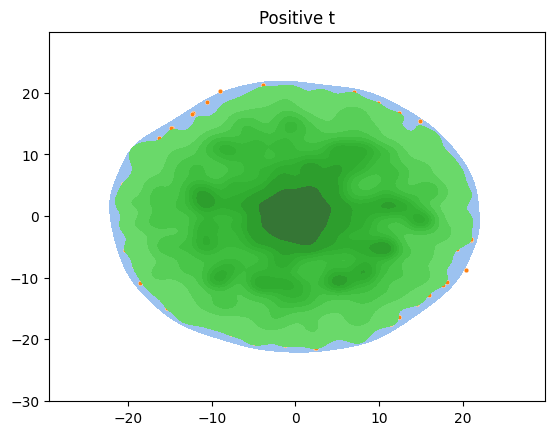

In [76]:
plt.ion()
f, ax = plt.subplots()
sn.kdeplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], fill=True)
sn.scatterplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], s=10)
sn.kdeplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], bw_adjust=0.5, fill=True)
plt.title("Positive t")
plt.show()